<a href="https://colab.research.google.com/github/mixo091/ML---Detecting-Anomalies/blob/main/Detecting_Anomalies(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ----- number of Time Series to dectect Anomalies ----
n = 5 
mae = 0.15

In [ ]:
#Imports..
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

#Step 1 : getting and saving the data appropriately.


In [ ]:
data = pd.read_csv("/content/nasdaq2007_17.csv",sep='\t',header=None)
print(data)


     0        1        2        3     ...    3647    3648    3649    3650
0       a  11.1440  10.4710  10.8280  ...   68.25   68.11   67.47   66.81
1      aa  47.4580  45.8700  46.2490  ...   46.97   45.89   43.33   43.01
2    aaba  13.8800  12.9700  13.2900  ...   72.22   71.16   70.19   70.56
3    aapl   1.2037   1.1589   1.1385  ...  174.18  175.61  175.25  174.67
4     abc  13.9910  13.4340  13.1950  ...   74.91   75.01   75.27   75.00
..    ...      ...      ...      ...  ...     ...     ...     ...     ...
354  xray  17.2850  16.9010  17.0160  ...   64.38   64.52   65.56   65.58
355   xrx  36.3880  35.2030  35.7070  ...   28.59   29.37   29.27   29.17
356   yum   8.2660   8.3172   8.2781  ...   81.01   81.13   79.53   79.59
357   zbh  46.3950  45.8150  42.1810  ...  108.72  109.17  111.84  110.75
358  zion  47.6690  46.6680  46.5700  ...   44.88   44.55   43.97   43.93

[359 rows x 3651 columns]


In [ ]:
# --- Keep only the prices for now --- 
stock_prices = data.drop(columns=0)
# --- Get the stocks --- .
stocks =  []
for i in range(0 , len(stock_prices)):
  stocks.append(   pd.DataFrame( np.array(stock_prices.iloc[i]).reshape(1,-1).T  , columns= ["close" ] ) )
# --- Now stocks list keeps the stocks as (3650,1) arrays. 
number_of_stocks = len(stocks)
print(len(stocks))
print(stocks[1].shape)
print(stocks[1])

359
(3650, 1)
       close
0     47.458
1     45.870
2     46.249
3     47.852
4     49.524
...      ...
3645  47.290
3646  46.970
3647  45.890
3648  43.330
3649  43.010

[3650 rows x 1 columns]



#Step 2: Calculating Train and Test sets.


In [ ]:
# --- Calculating set sizes ---

train_size = int( len(stocks[1]) *  0.80)
test_size =  len(stocks[1])  - train_size

print("Train size :" + str(train_size))
print("Test size :" + str(test_size))



Train size :2920
Test size :730


In [ ]:
train_set = []
test_set = []

for i in range(0 , len(stocks)):
  train_set.append(stocks[i][0:train_size])
  test_set.append(stocks[i][train_size:])

print(len(train_set[1]))
print(train_set[1])
print(" ---------------------------------- ")
print(len(test_set[1]))

2920
       close
0     47.458
1     45.870
2     46.249
3     47.852
4     49.524
...      ...
2915  32.386
2916  32.513
2917  31.428
2918  32.777
2919  34.368

[2920 rows x 1 columns]
 ---------------------------------- 
730


#Step 3 : Let's scale our Data.

In [ ]:
# --- Scale Data ---
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_train_set = []
scaler = scaler.fit(train_set[1])
for i in range(0,len(train_set)):
  scaled_train_set.append(scaler.transform(train_set[i]))

# -------------------------------------------------------------------------- # 
scaled_test_set = []
scaler = scaler.fit(test_set[1])
for i in range(0,len(test_set)):
  scaled_test_set.append(scaler.transform(test_set[i]))

print(scaled_train_set[1])
print(scaled_train_set[1].shape)
print(scaled_test_set[1].shape)


[[0.41560848]
 [0.39755585]
 [0.40186438]
 ...
 [0.23337691]
 [0.24871256]
 [0.2667993 ]]
(2920, 1)
(730, 1)



# Step 4 : Concatanate the chossen set of training stocks.

In [ ]:
#--- Concatanate scaled train set ----
# i will use 50 stocks in this set.
con_train_set = np.concatenate([scaled_train_set[0],scaled_train_set[1]])
for i in range(2,50):
  con_train_set= np.concatenate([con_train_set,scaled_train_set[i]])

print(con_train_set.shape)

(146000, 1)


#Step 5 : Split data Into subSeuquences .

In [ ]:
# a function to do that

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 20


train = pd.DataFrame(con_train_set, columns = ['close'])

print(len(scaled_test_set))
print(number_of_stocks)

test = []
for i in range(0 , n ):
  test.append (pd.DataFrame(scaled_test_set[number_of_stocks -1 - i], columns=['close']))

X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test_list = []
y_test_list = []

for i in range(0 , n ):
  X_test, y_test = create_dataset(test[i][['close']], test[i].close, TIME_STEPS)
  X_test_list.append(X_test)
  y_test_list.append(y_test)



359
359


In [ ]:
print(X_train.shape)
print(X_test_list[1].shape)
print(X_test_list[2].shape)

(145980, 20, 1)
(710, 20, 1)
(710, 20, 1)


#Step 6 : Let's create our Autoencoder in *Keras* and Train our Model -- Experimenting Stage --
Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras:

In [ ]:
"""model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.5))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)
model.compile(loss='mae', optimizer='adam') """

"model = keras.Sequential()\nmodel.add(keras.layers.LSTM(\n    units=64,\n    input_shape=(X_train.shape[1], X_train.shape[2])\n))\nmodel.add(keras.layers.Dropout(rate=0.5))\nmodel.add(keras.layers.RepeatVector(n=X_train.shape[1]))\nmodel.add(keras.layers.Dropout(rate=0.5))\nmodel.add(keras.layers.LSTM(units=64, return_sequences=True))\nmodel.add(keras.layers.Dropout(rate=0.5))\nmodel.add(\n  keras.layers.TimeDistributed(\n    keras.layers.Dense(units=X_train.shape[2])\n  )\n)\nmodel.compile(loss='mae', optimizer='adam') "

In [ ]:
 """history = model.fit(
    X_train, y_train,
    epochs=8,
    batch_size=248,
    validation_split=0.4,
    shuffle=False
 )"""



'history = model.fit(\n   X_train, y_train,\n   epochs=8,\n   batch_size=248,\n   validation_split=0.4,\n   shuffle=False\n)'

In [ ]:
import os.path
if os.path.isfile("./finalModel.h5") is False:
  model.save("./finalModel.h5")

In [ ]:
from tensorflow.keras.models import load_model
new_model = load_model("./finalModel.h5")
new_model.summary()
model = new_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                        

In [ ]:



plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();




NameError: ignored

In [ ]:
X_train_pred = model.predict(X_train)


train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Step 7 : Finding Anomalies.


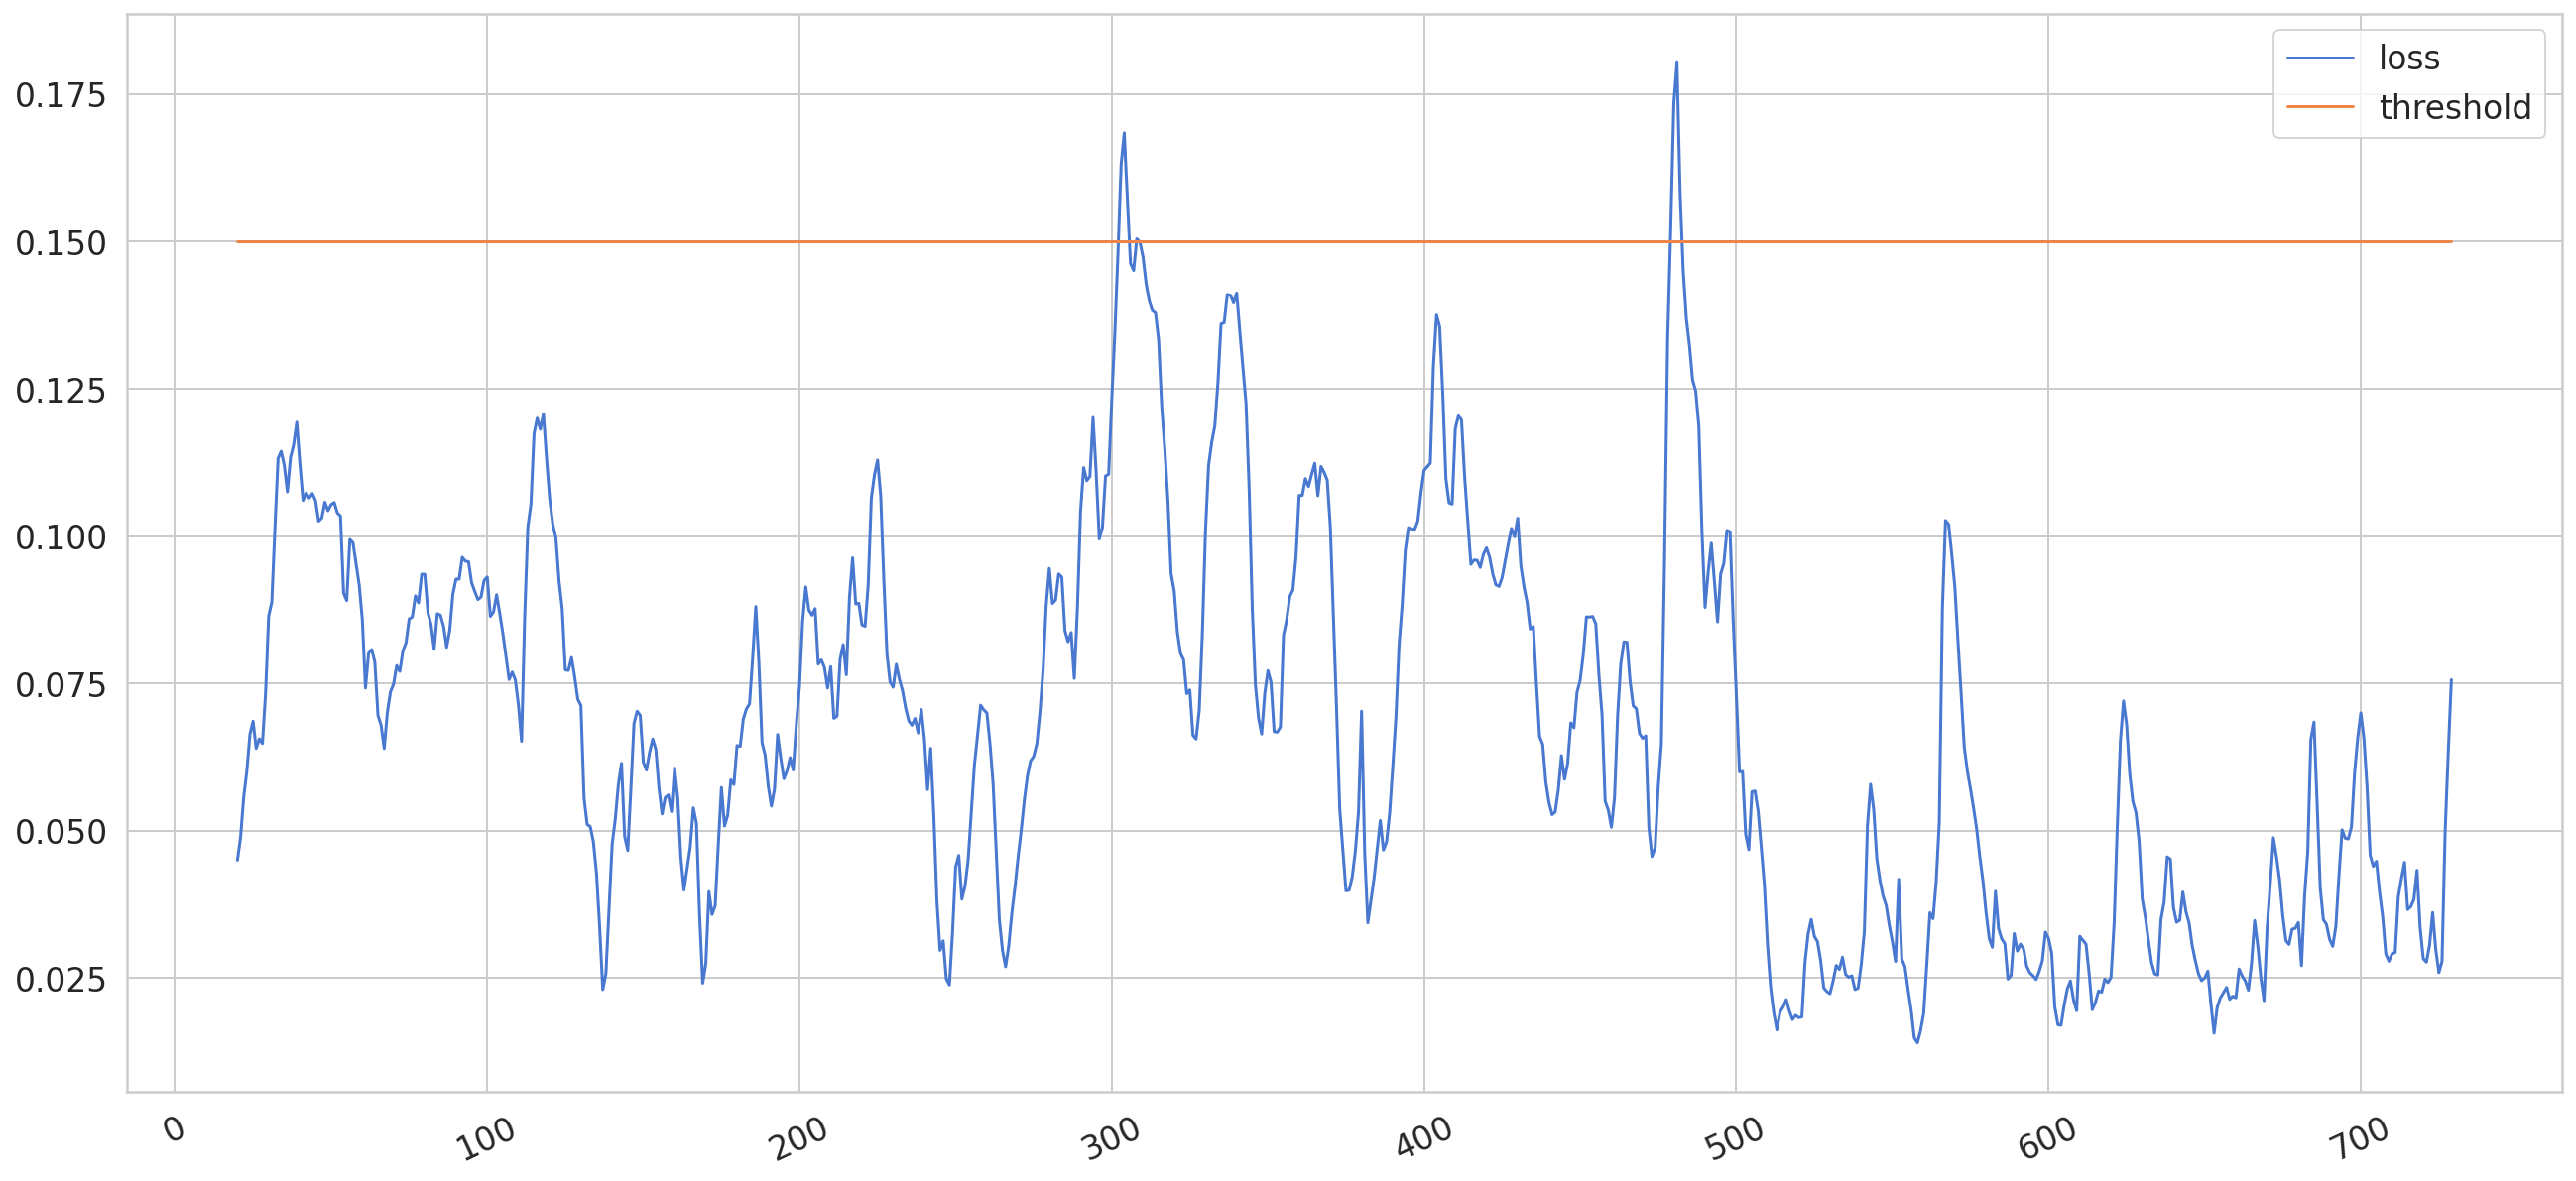

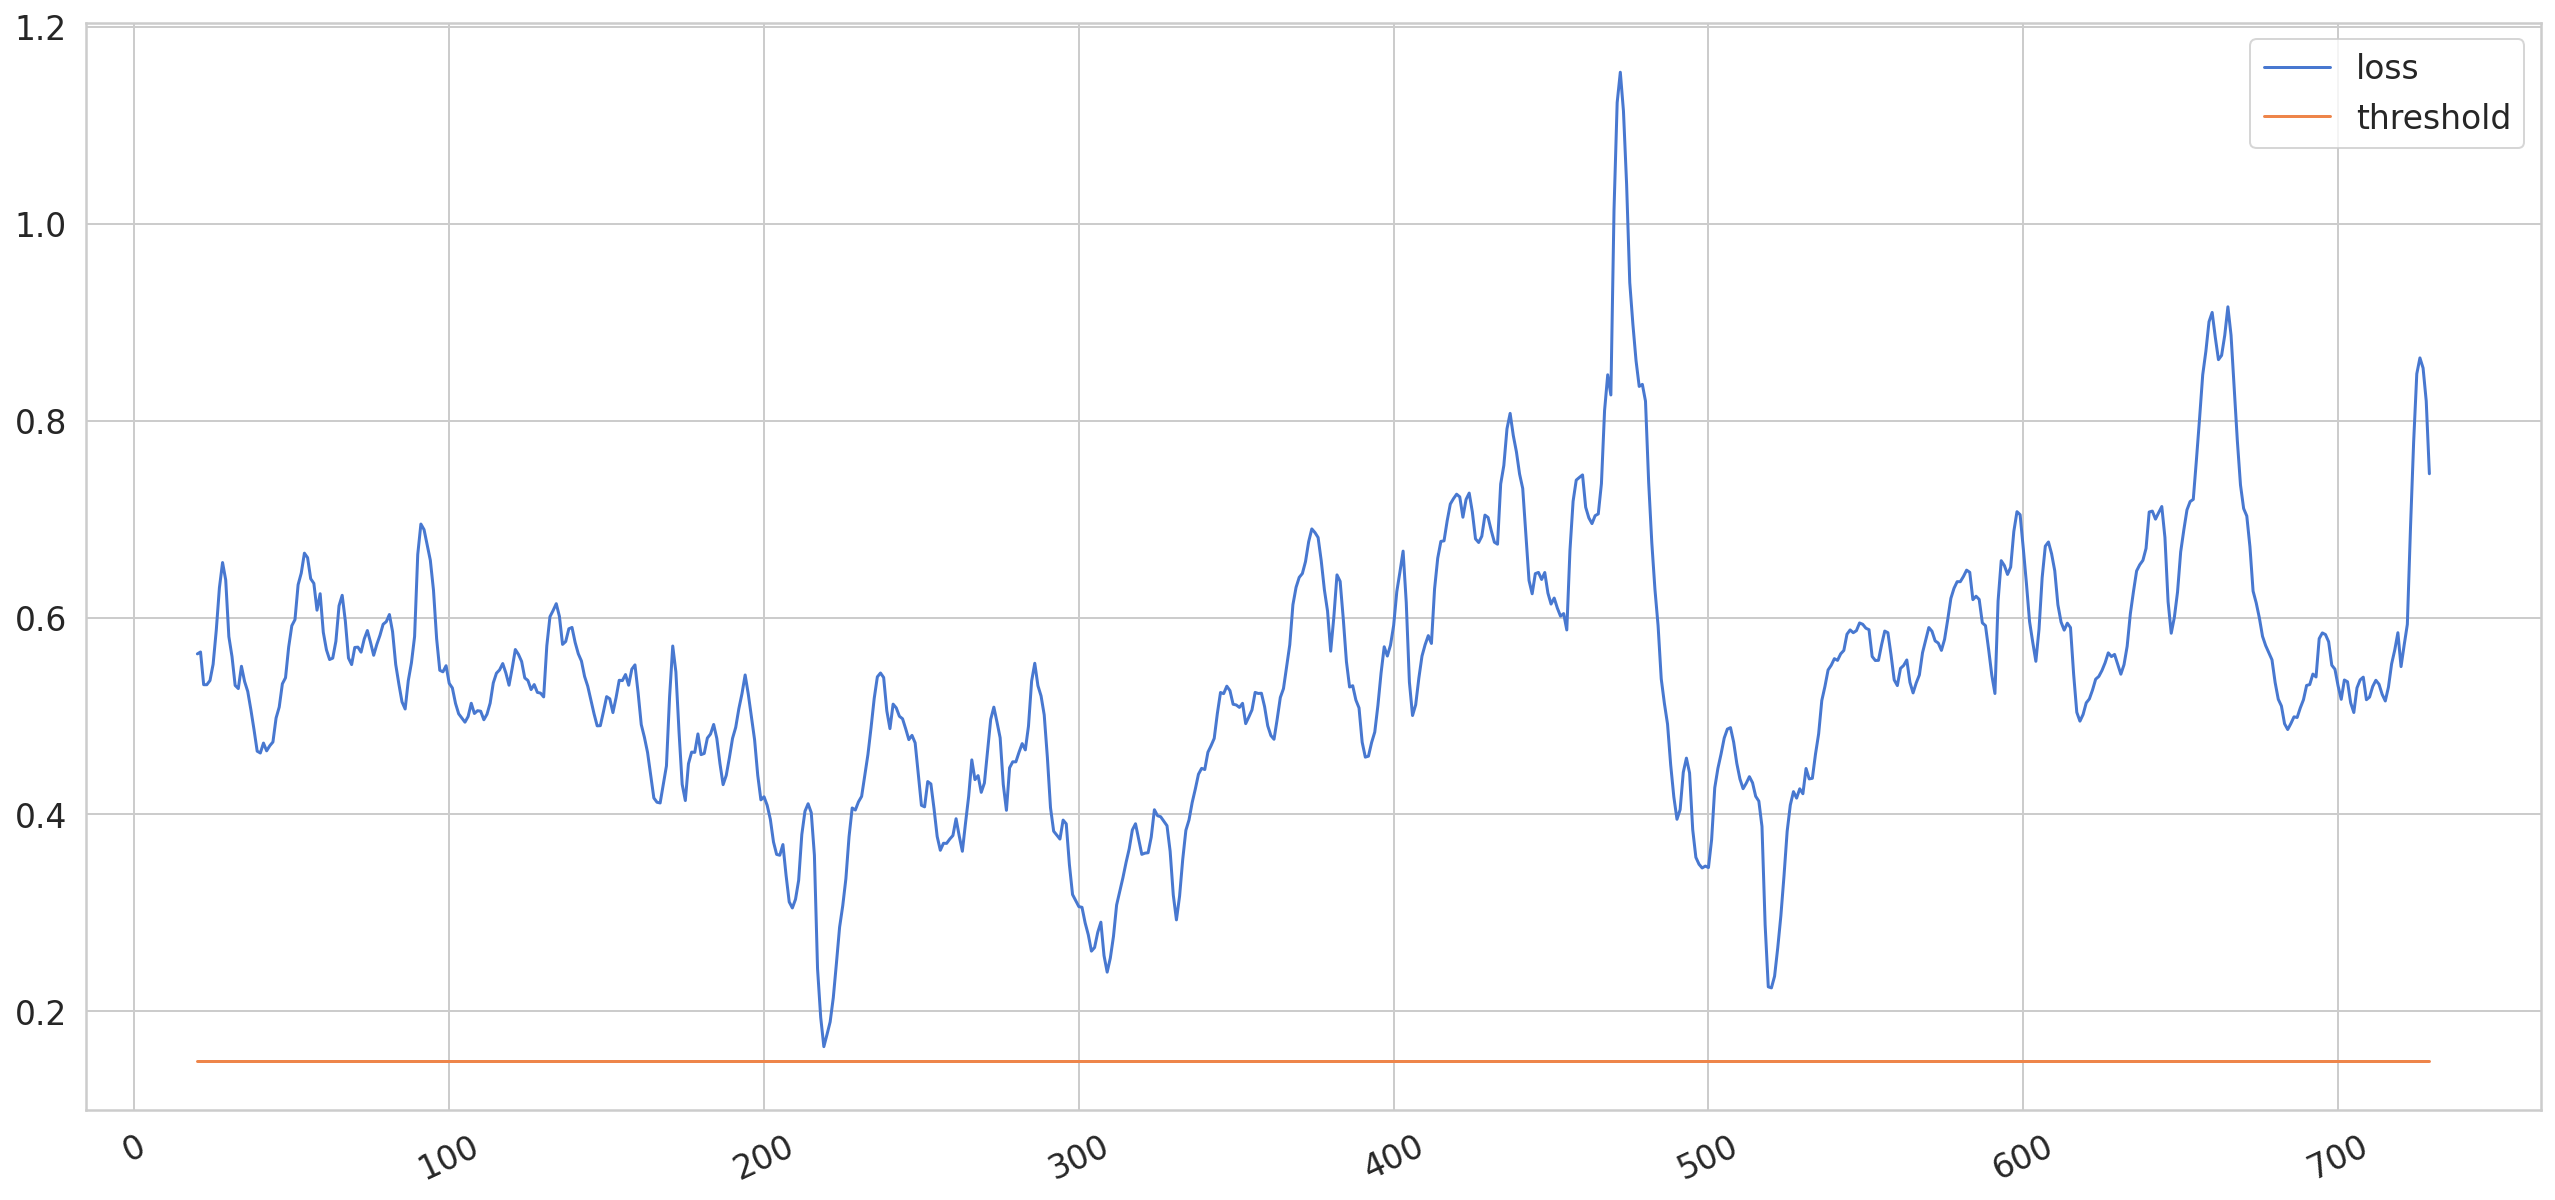

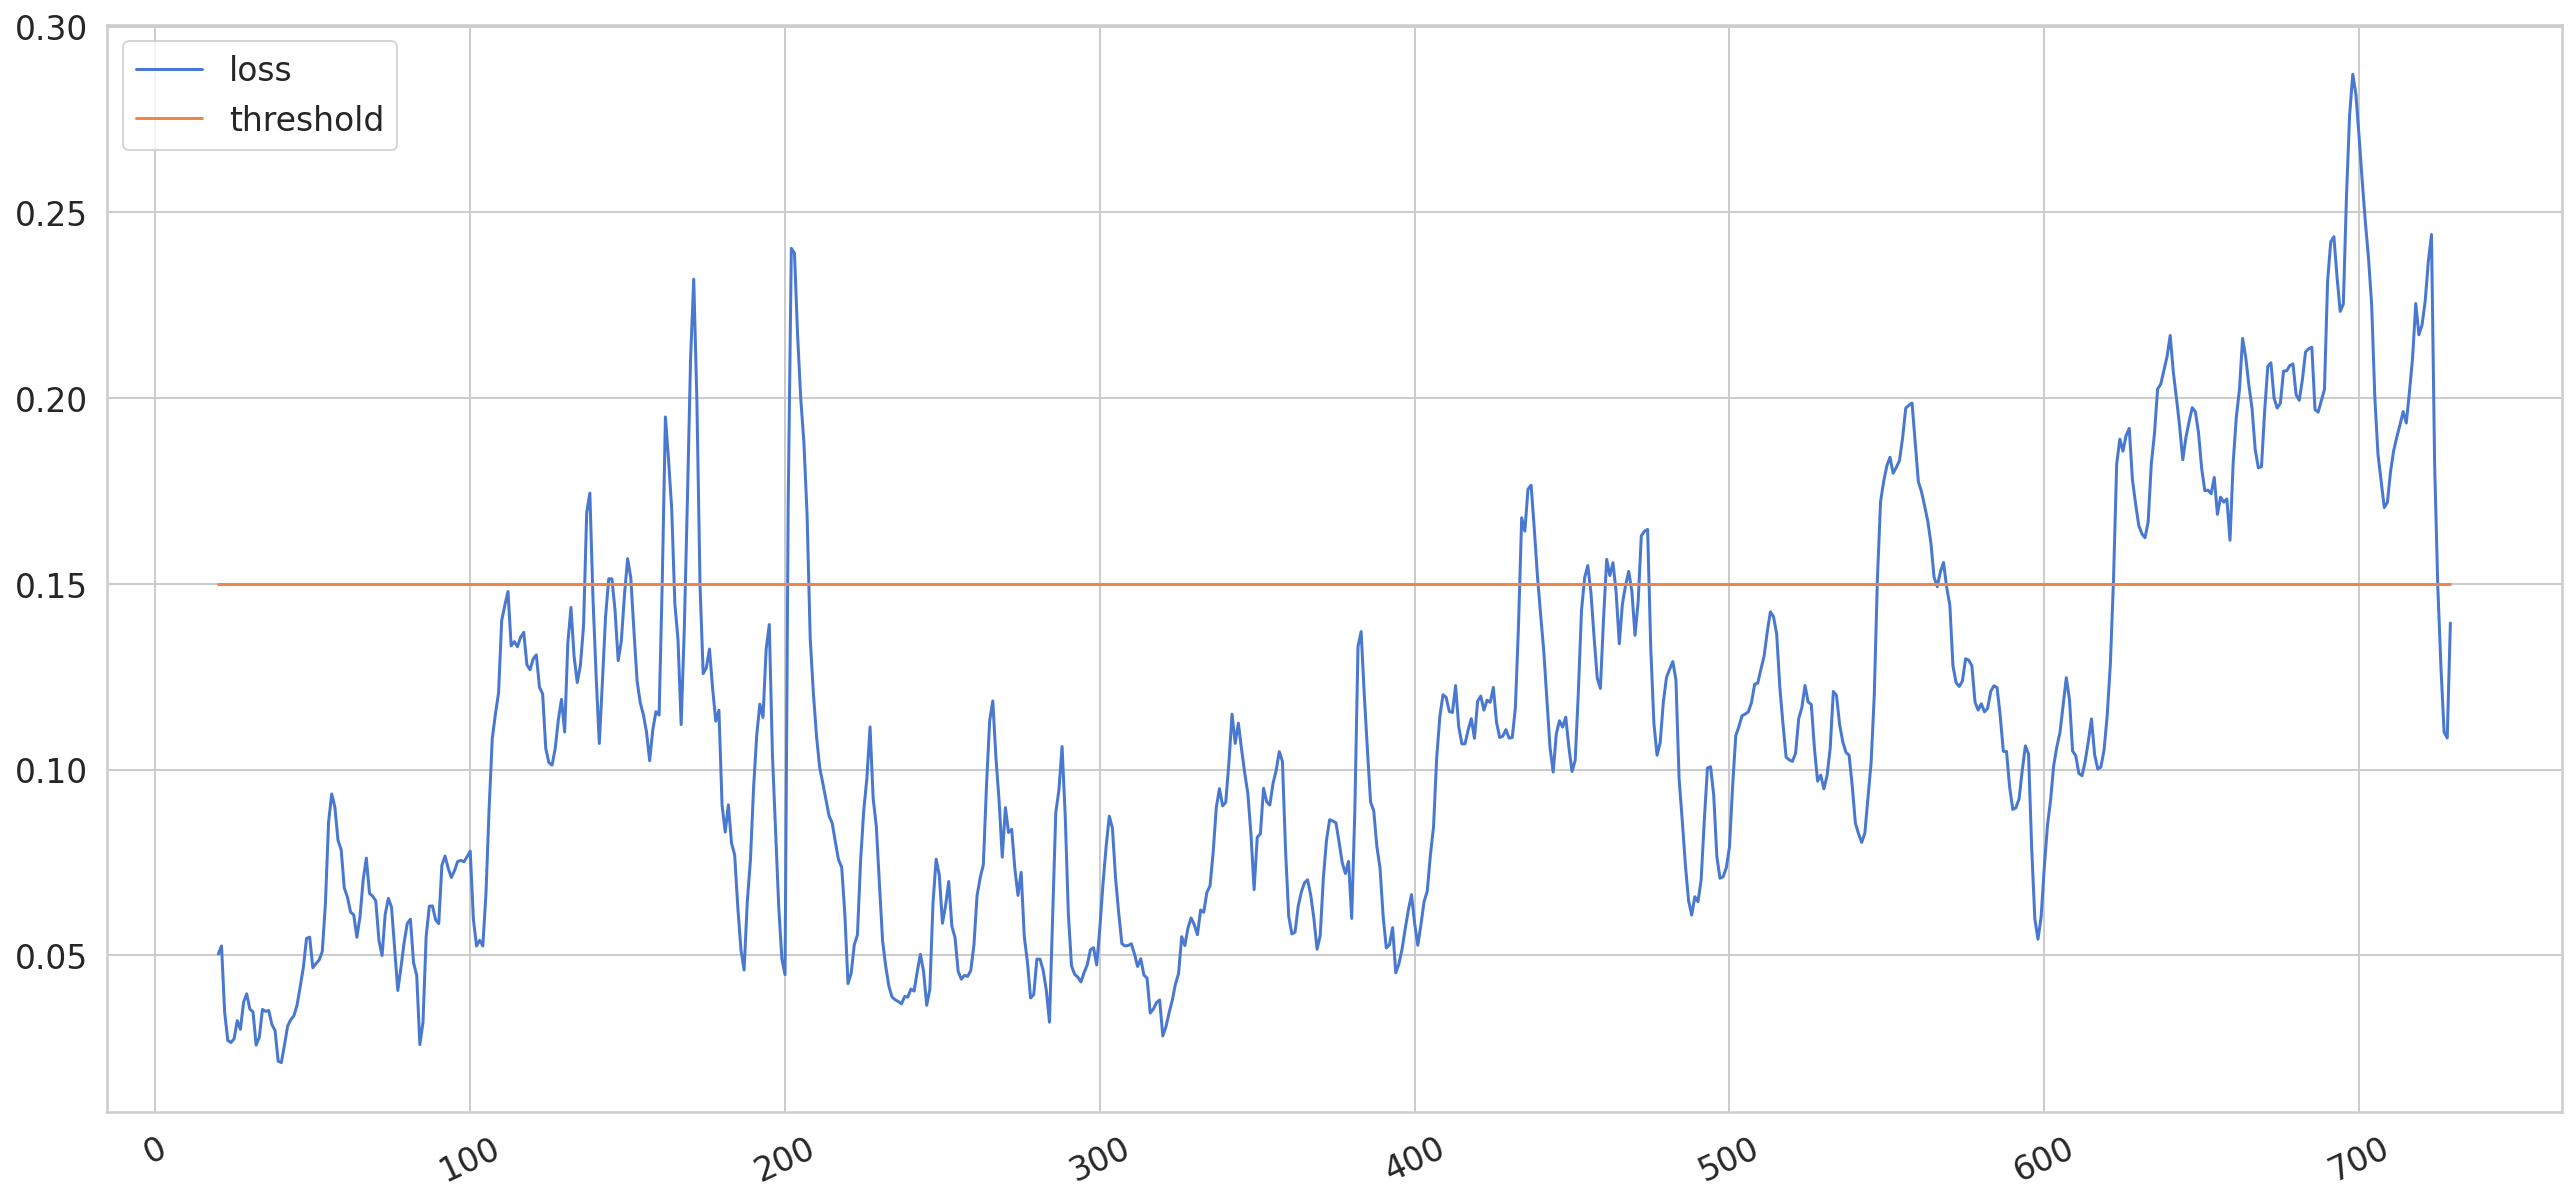

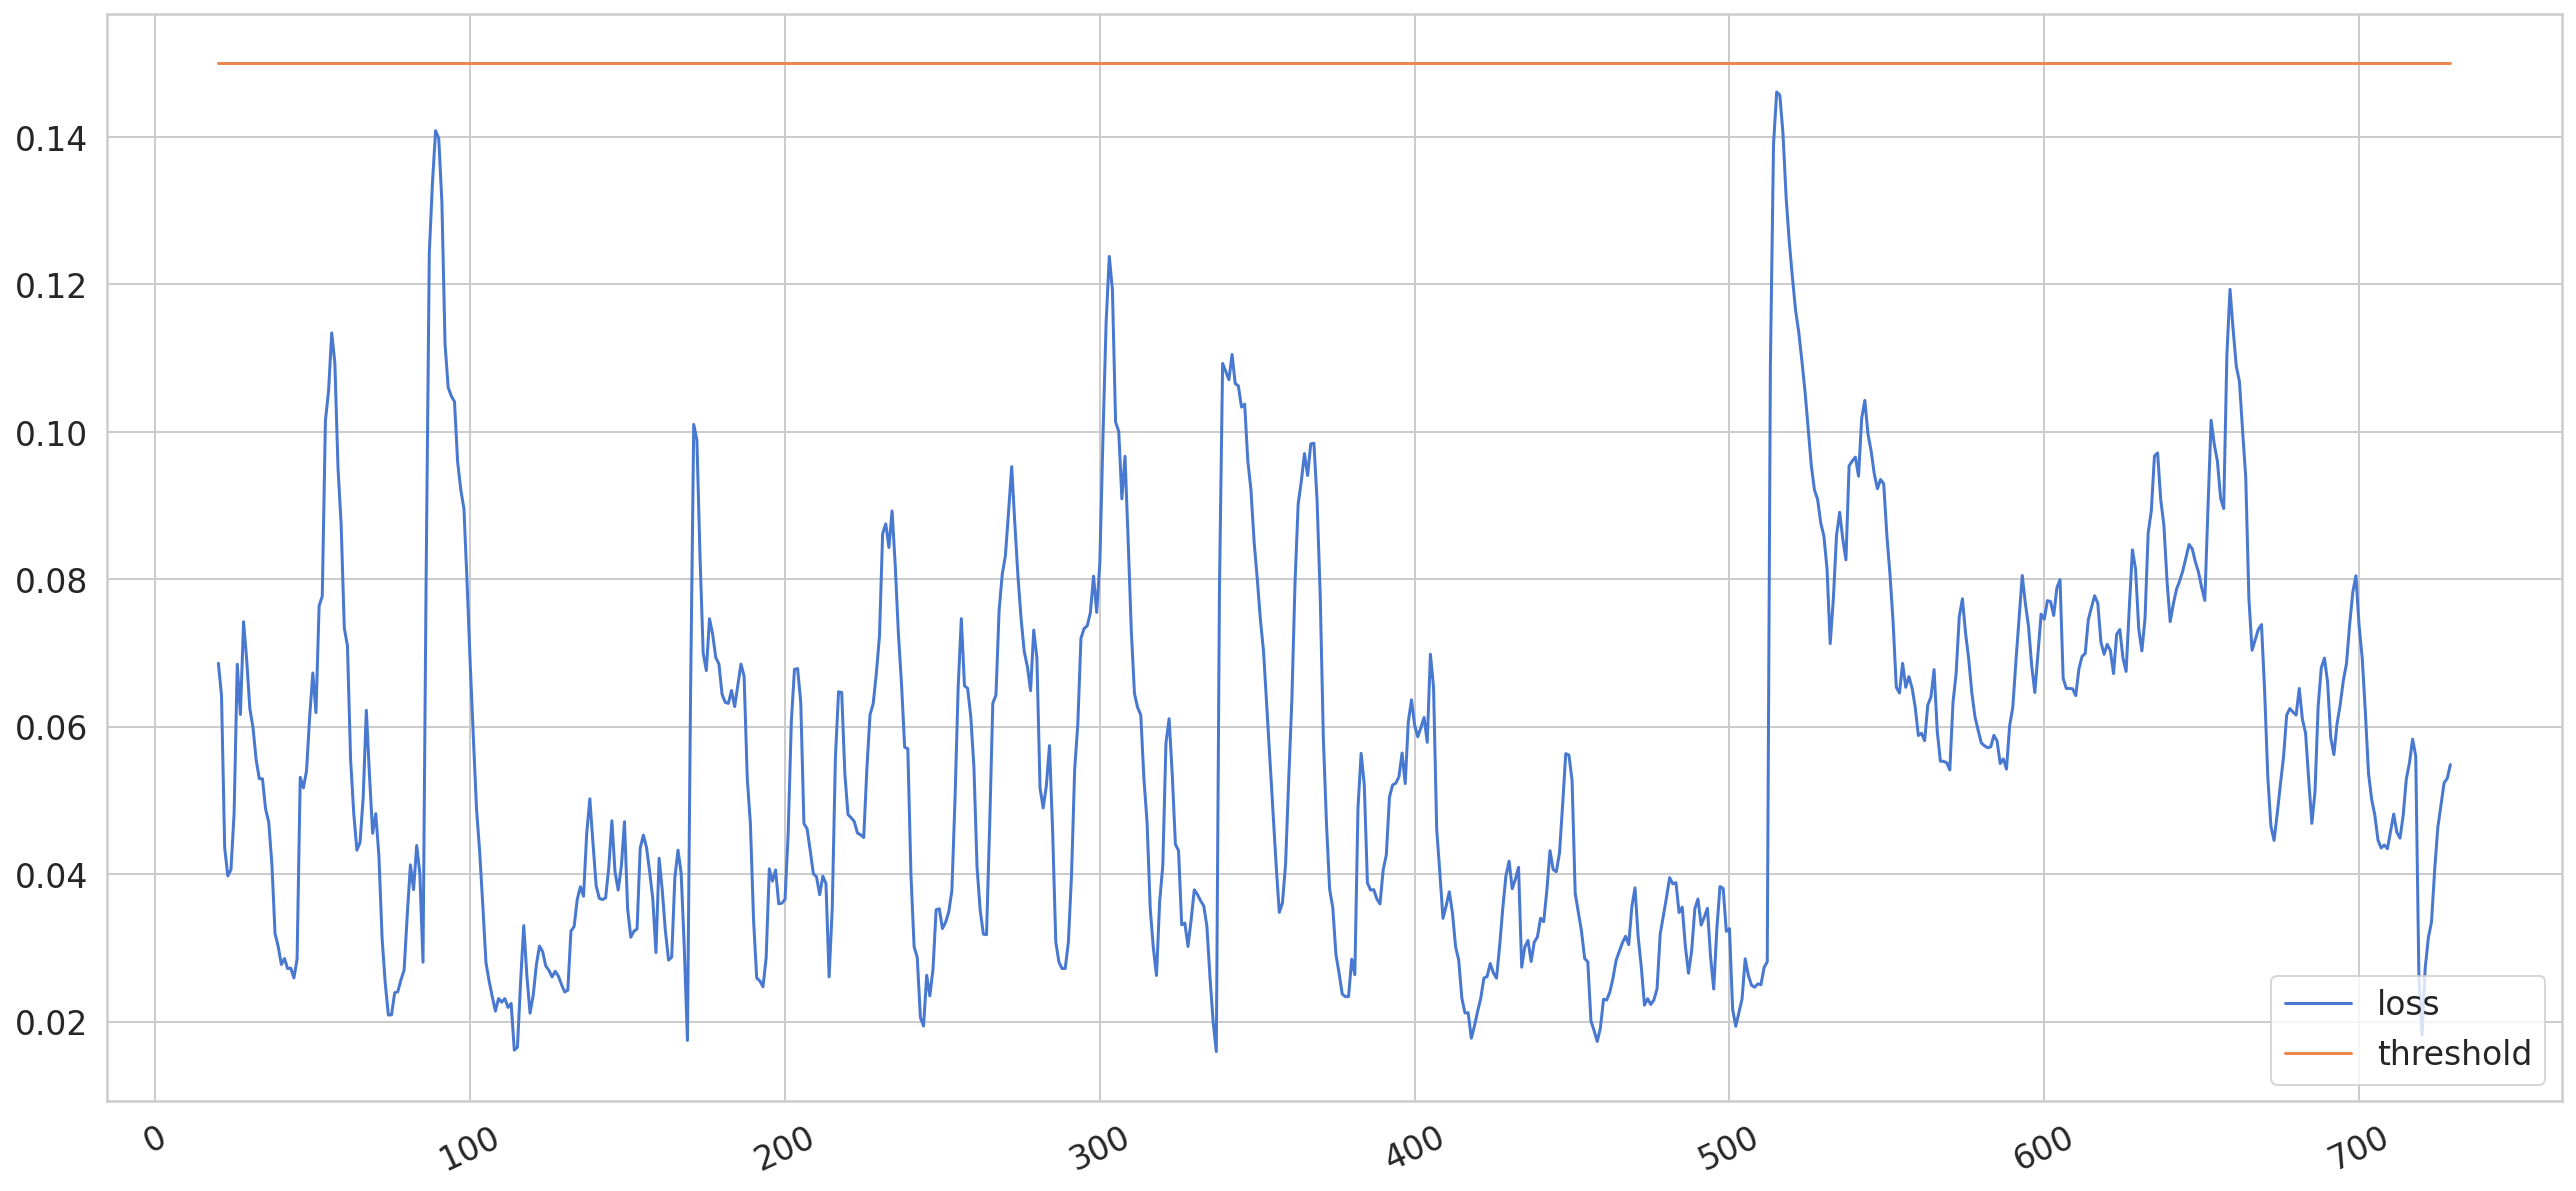

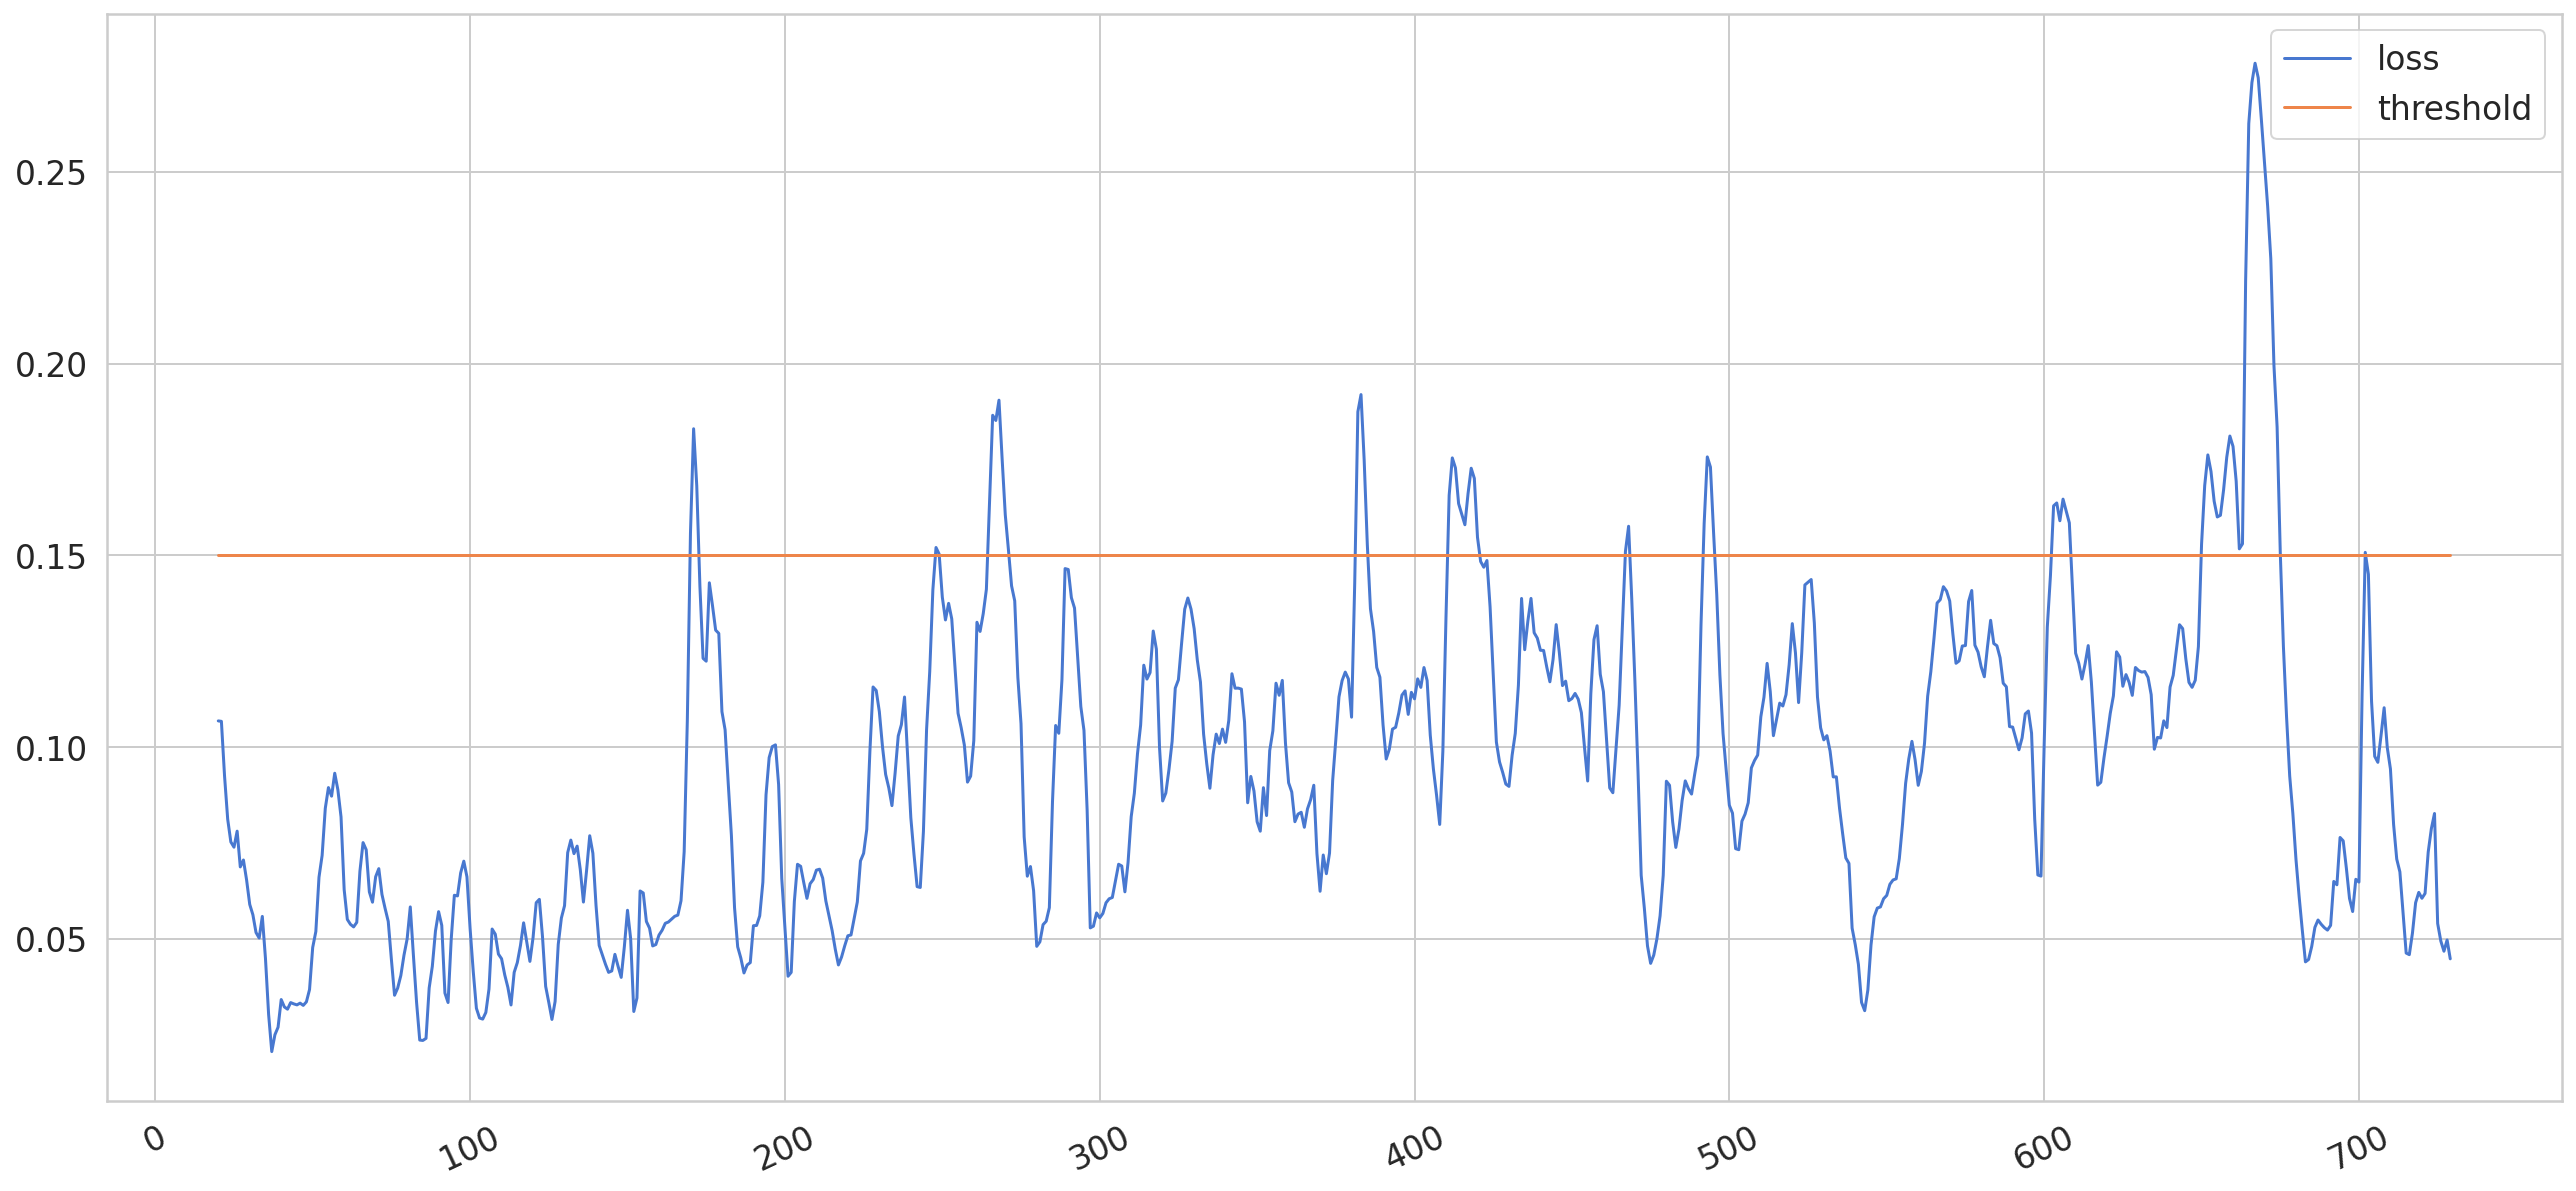

In [ ]:
THRESHOLD = mae


test_score_df = []
dfs = []
for i in range(0,n):
  plt.figure()
  df = pd.DataFrame(scaled_test_set[i], columns = ['close'])
  dfs.append(df)
  #print(df)
  X_test_pred = model.predict(X_test_list[i])
  test_mae_loss = np.mean(np.abs(X_test_pred - X_test_list[i]), axis=1)
  test_score_df.append(pd.DataFrame(index =df[TIME_STEPS:].index))
  test_score_df[i]['loss'] = test_mae_loss
  test_score_df[i]['threshold'] = THRESHOLD
  test_score_df[i]['anomaly'] = test_score_df[i].loss > test_score_df[i].threshold
  test_score_df[i]['close'] = df[TIME_STEPS:].close
  plt.plot(test_score_df[i].index, test_score_df[i].loss, label='loss')
  plt.plot(test_score_df[i].index, test_score_df[i].threshold, label='threshold')
  plt.xticks(rotation=25)
  plt.legend();


In [ ]:
  anomalies = []
  for i in range(0,n):
    anomalies.append ( test_score_df[i][test_score_df[i].anomaly == True] )
    print(anomalies[i].head())

         loss  threshold  anomaly     close
303  0.163101       0.15     True  0.678317
304  0.168446       0.15     True  0.640954
305  0.156955       0.15     True  0.642089
308  0.150499       0.15     True  0.666856
479  0.152203       0.15     True  0.852932
        loss  threshold  anomaly     close
20  0.563095       0.15     True  0.562853
21  0.565010       0.15     True  0.570286
22  0.531782       0.15     True  0.553065
23  0.531790       0.15     True  0.572754
24  0.536015       0.15     True  0.562853
         loss  threshold  anomaly     close
137  0.169176       0.15     True  0.646231
138  0.174434       0.15     True  0.655026
144  0.151373       0.15     True  0.700984
145  0.151353       0.15     True  0.706375
150  0.156788       0.15     True  0.649352
Empty DataFrame
Columns: [loss, threshold, anomaly, close]
Index: []
         loss  threshold  anomaly     close
170  0.155727       0.15     True  2.252716
171  0.182985       0.15     True  2.340464
172  0.168088

(710, 1)
(8, 1)
(8,)
(710, 1)
(710, 1)
(710,)
(710, 1)
(160, 1)
(160,)
(710, 1)
(65, 1)
(65,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

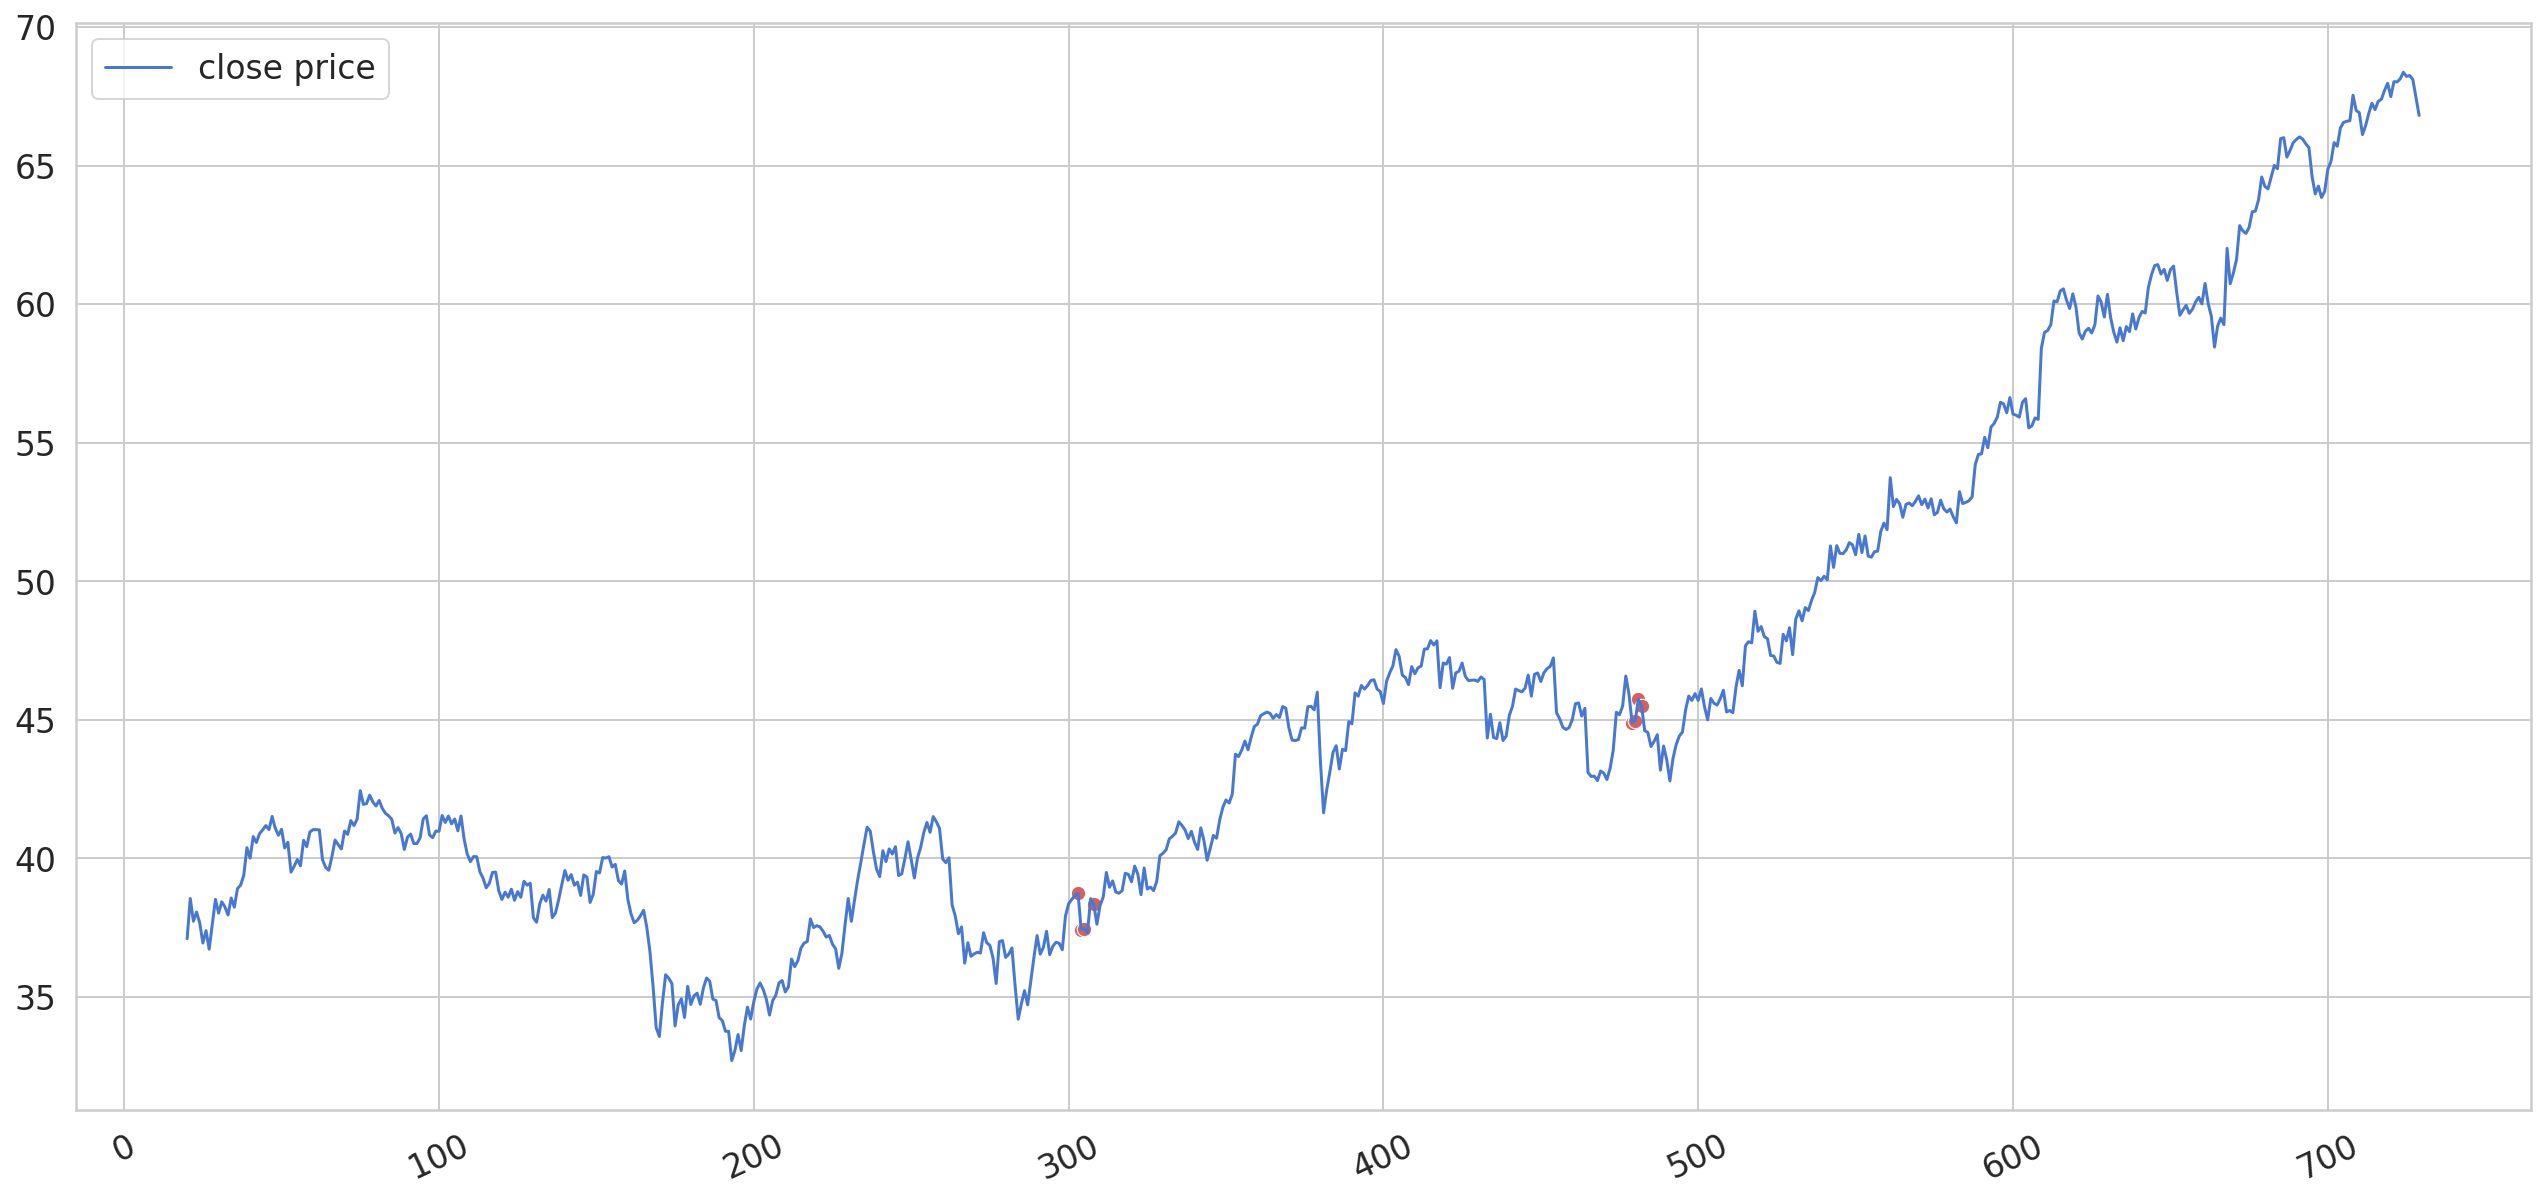

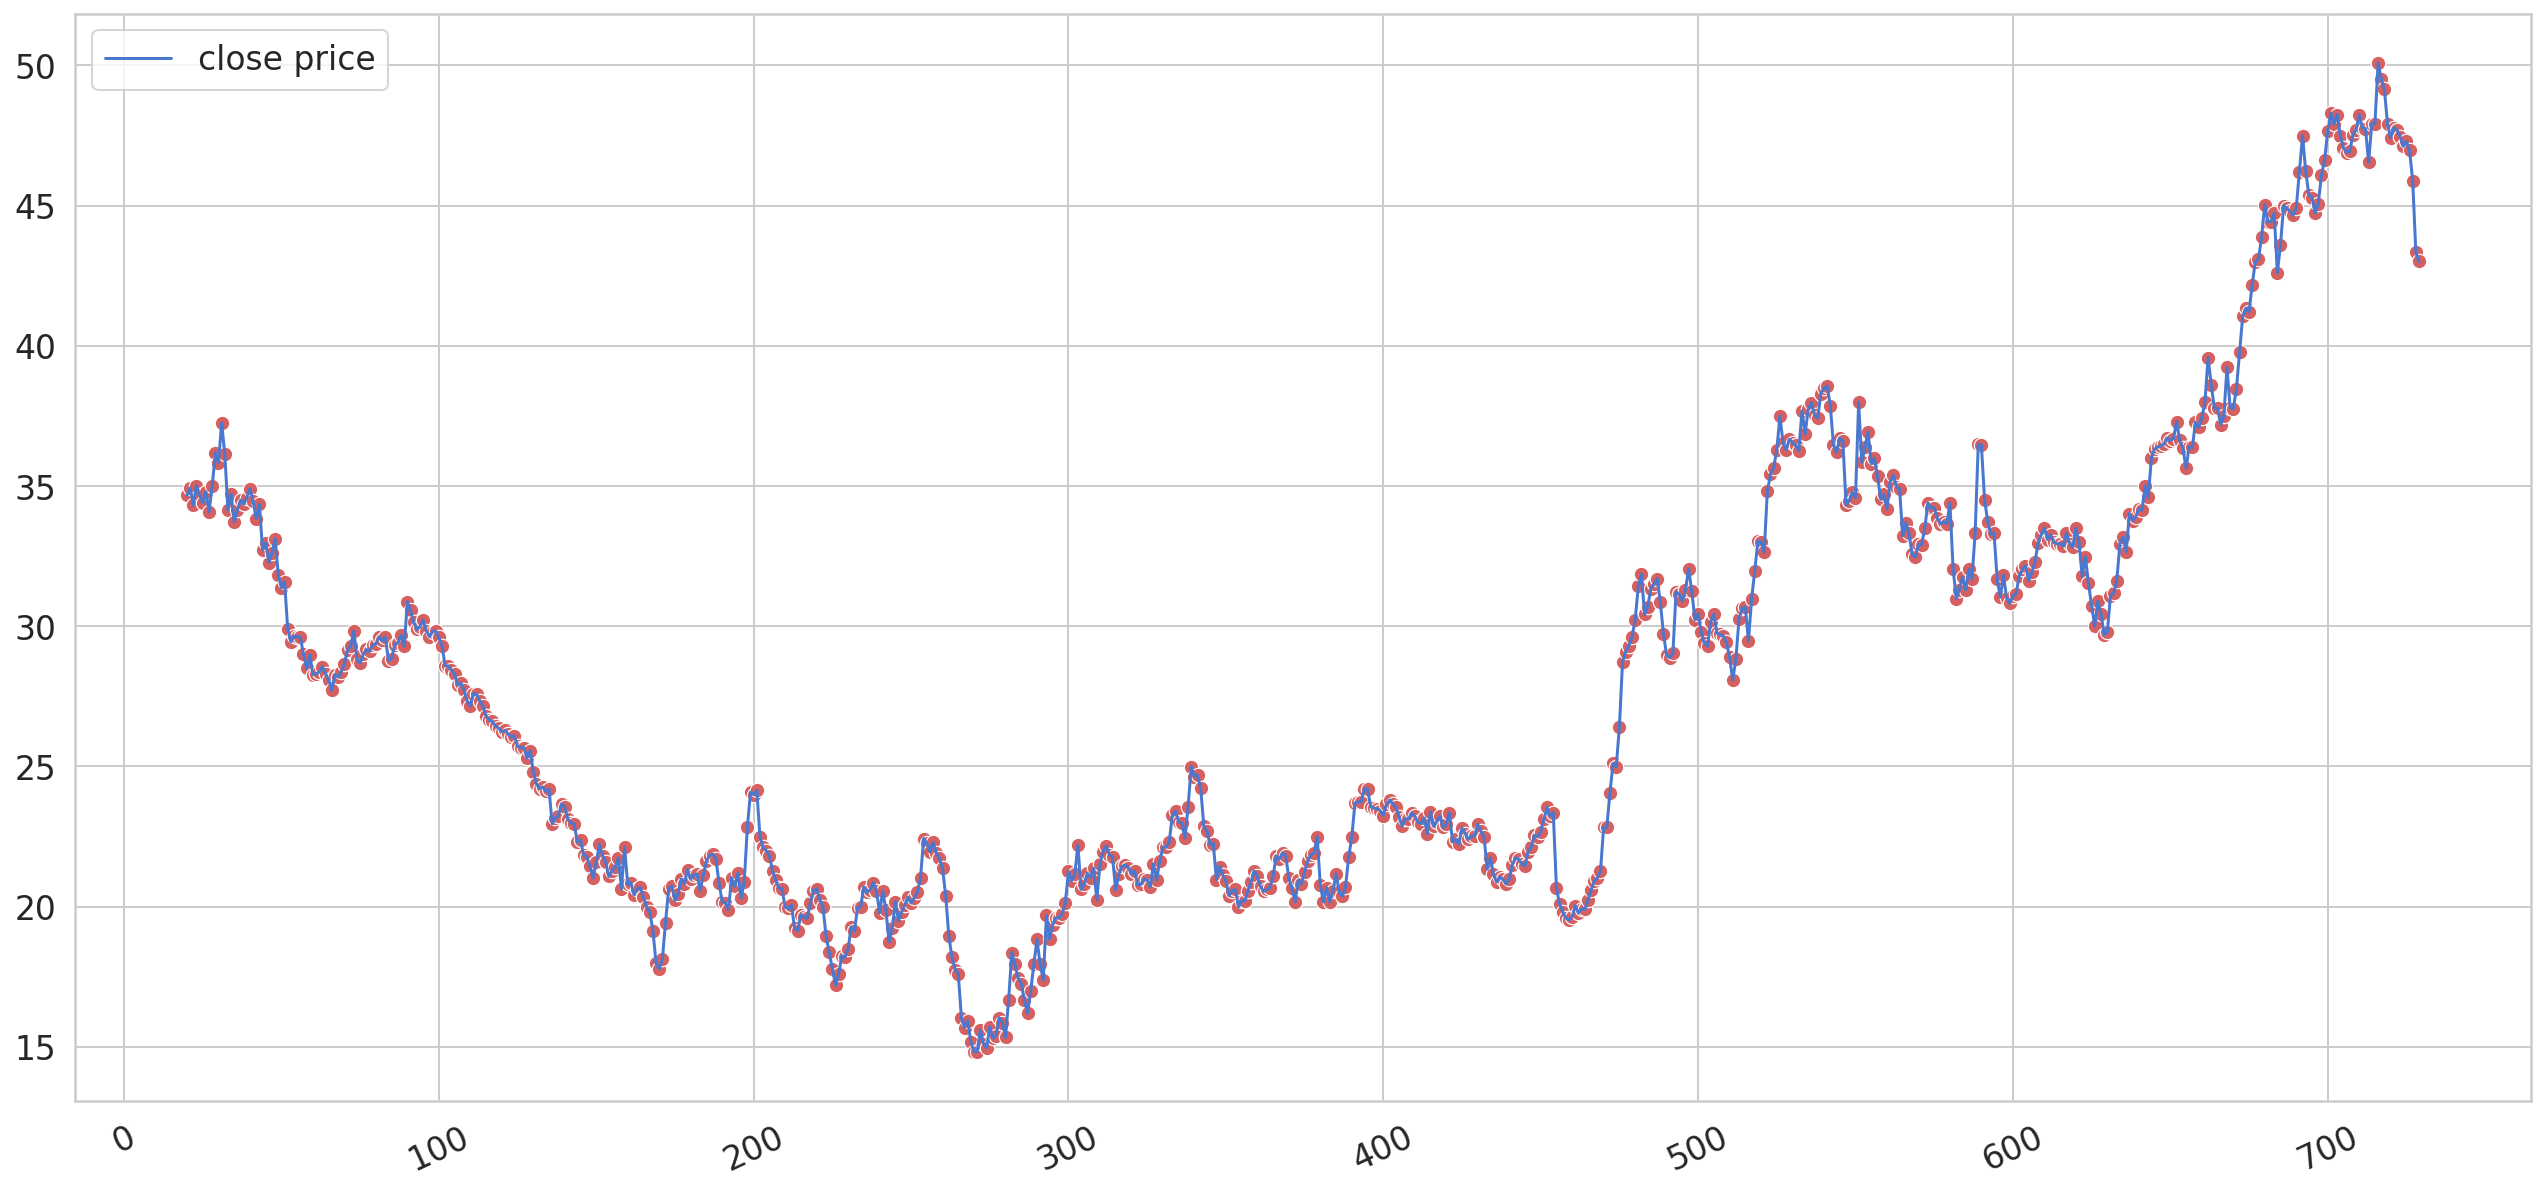

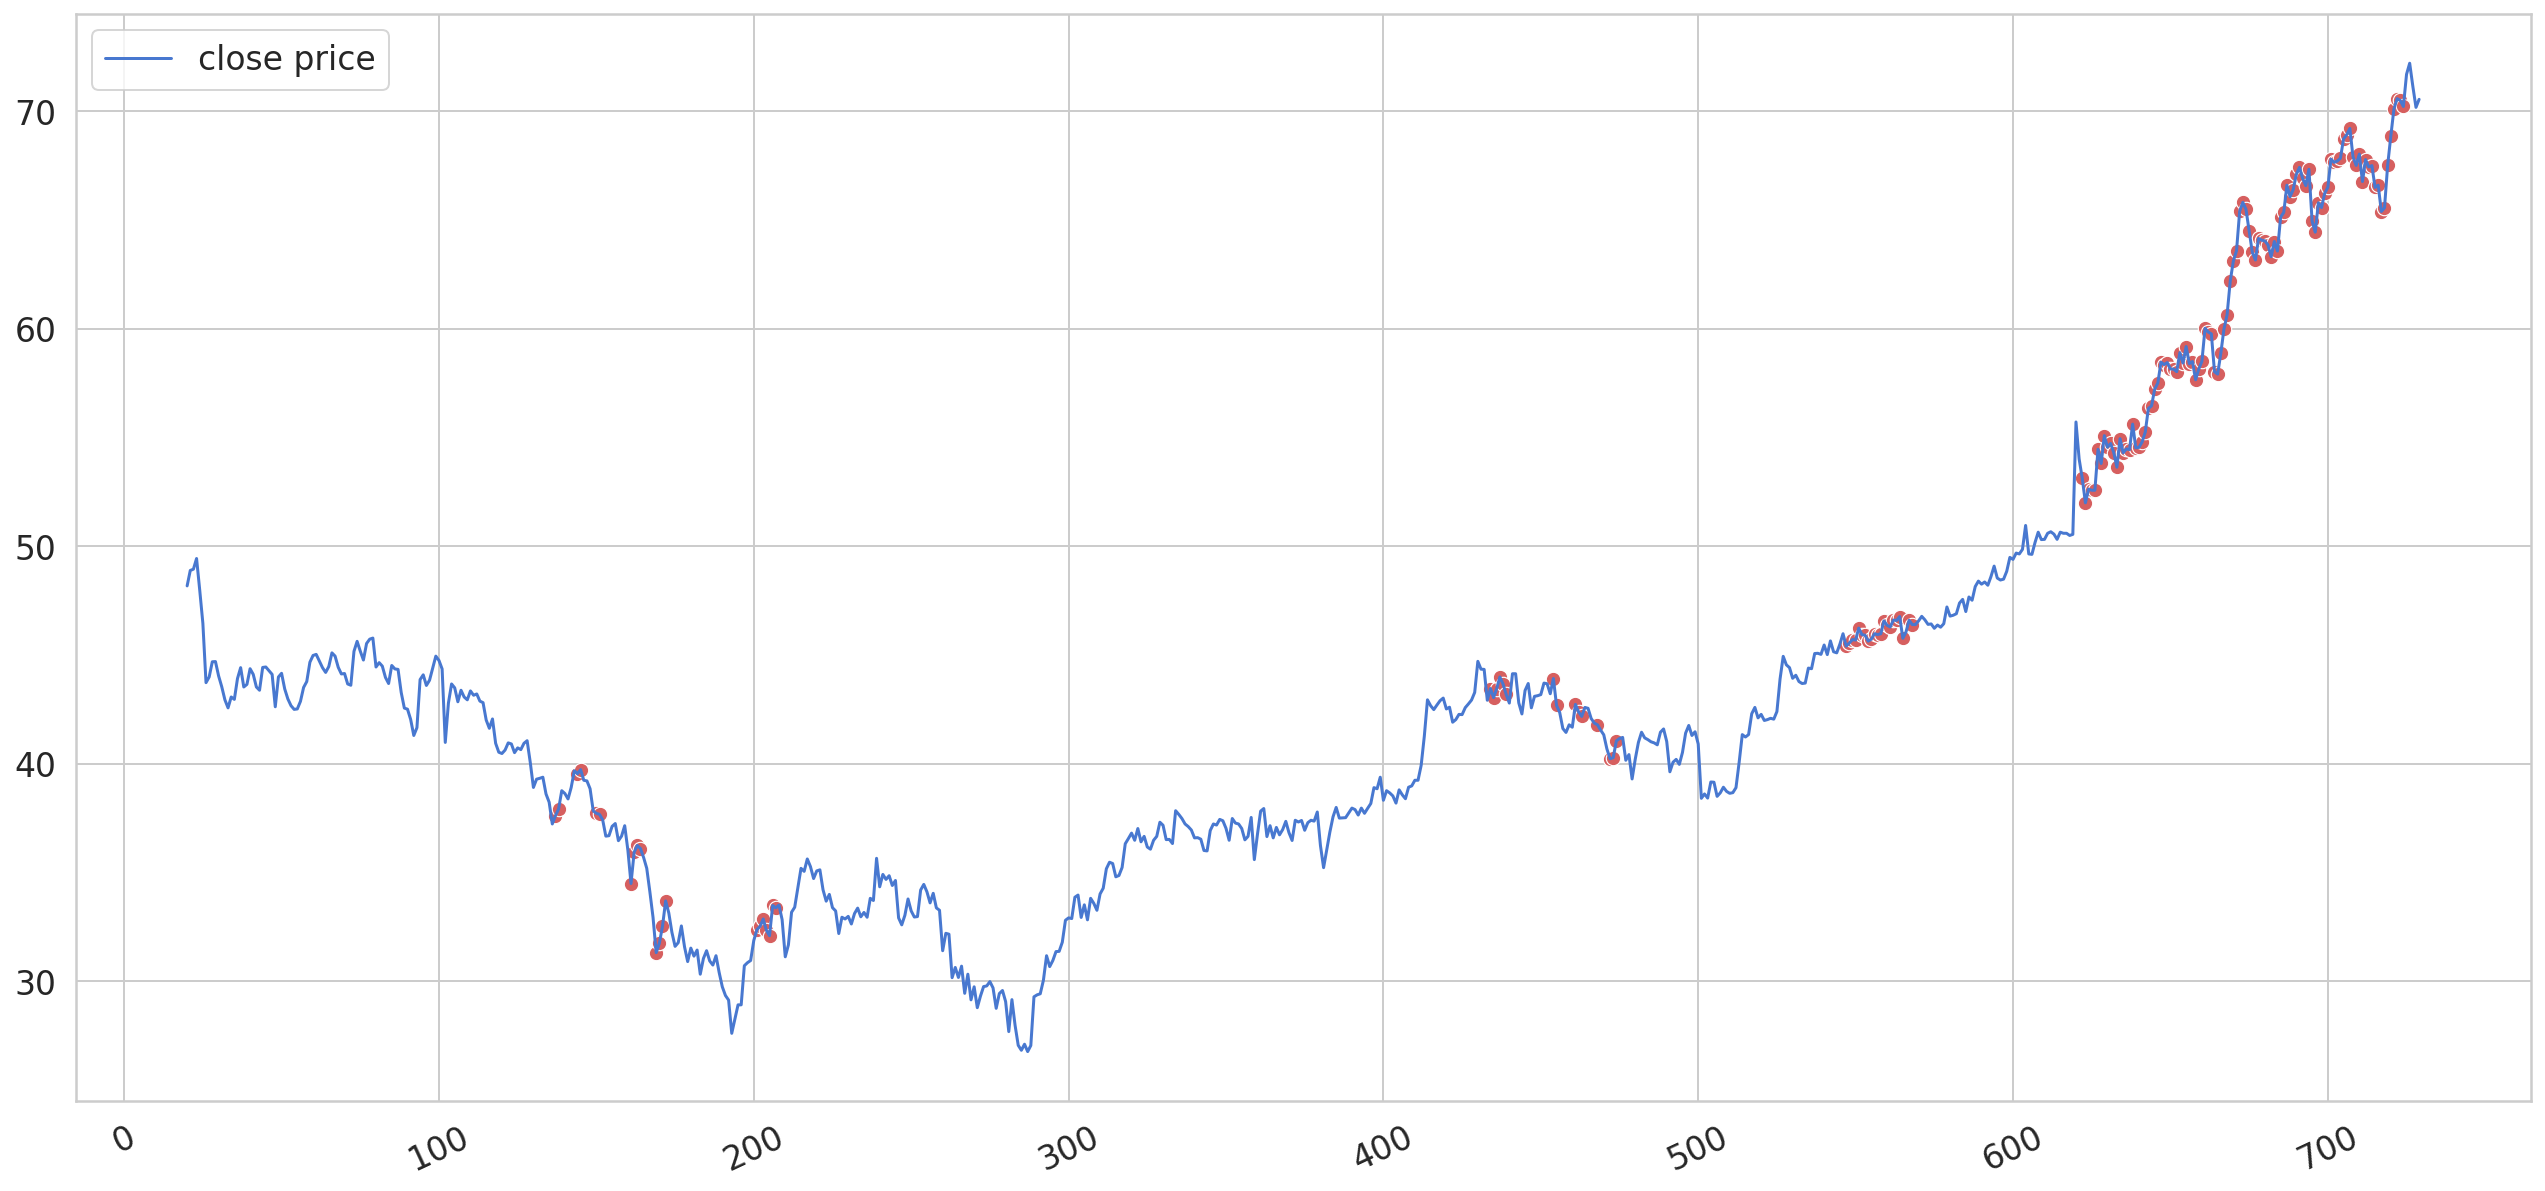

<Figure size 1584x720 with 0 Axes>

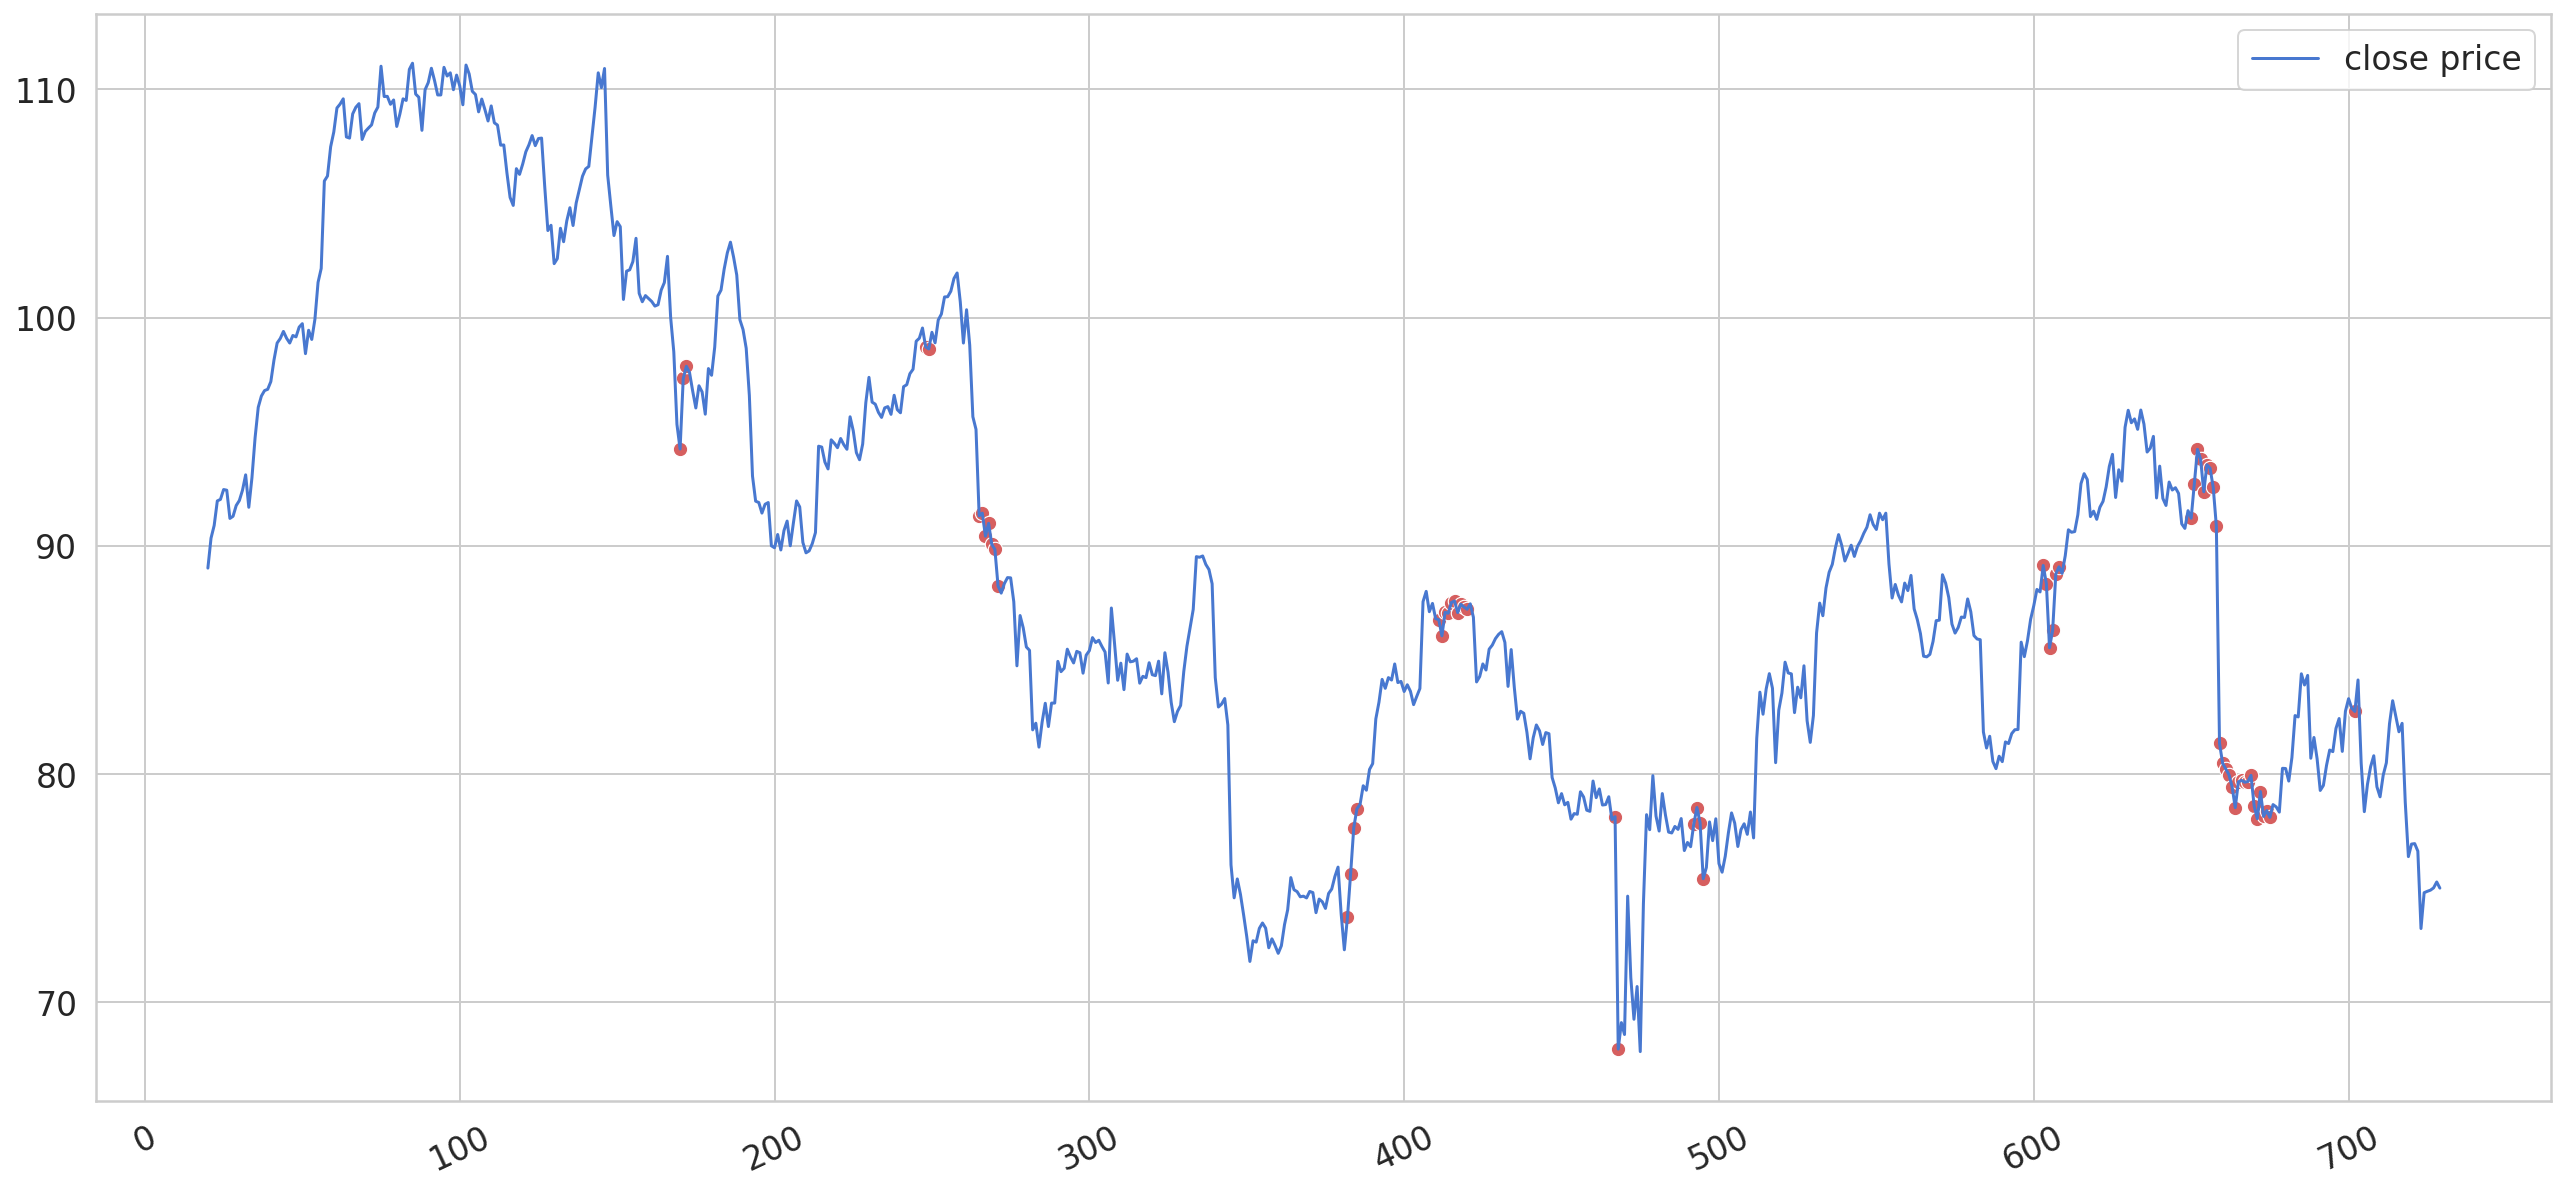

In [ ]:







for i in range(0,n):
    plt.figure()
    if(len(anomalies[i]) >= 1):
  
        new = np.array(dfs[i][TIME_STEPS:].close).reshape(1,-1).T
        print(new.shape)
        anomalies_new = np.array(anomalies[i].close).reshape(1,-1).T
        print(anomalies_new.shape)
        scaled = scaler.inverse_transform(anomalies_new)
        d = scaled.flatten()
        print(d.shape)

        plt.plot(
          dfs[i][TIME_STEPS:].index, 
          scaler.inverse_transform(new ), 
          label='close price'
        );

        sns.scatterplot(
          anomalies[i].index,
          d,
          color=sns.color_palette()[3],
          s=52,
        
        )
        plt.xticks(rotation=25)
        plt.legend();
